# Instructions
The following code was designed in order to read batch files from EzTrack Freezing Analysis.

## 1. Load necessary packages

In [20]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import fnmatch
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2. Set directory and task parameters
Inside the directory to be analysed there should be folders with 'exp_days' and a csv files with subjects info. Inside each 'exp_days' folder there will be 'camera' folders. User needs to set which camera to analyse.

In [21]:
exp_dict={
'directory' : '/Users/anacarolinabotturabarros/University of Glasgow/kohl-lab - RSCABAPP2/Experiments/cohoAPP4_fmcfc2_AB/',
'exp_days' : ['Habituation1', 'Habituation2', 'Conditioning', 'Recall1', 'Recall2'],
'camera' : 'topview',
}

### Load Subjects File

In [22]:
cb_file = [f for f in os.listdir(exp_dict['directory']) if f.endswith('.csv')][0]

cb_info = pd.read_csv(os.path.join(exp_dict['directory'], cb_file))

cb_info

Mouse ID  Run Habituation Recall
0      mA1    1          AB     AB
1      mA3    2          AB     AB
2     mA10    3          AB     AB
3      mB1    4          AB     BA
4      mB2    5          AB     BA
5      mB3    6          BA     BA
6      mC1    7          BA     BA
7      mC2    8          BA     BA
8      mC3    9          BA     AB
9      mC4   10          BA     AB

## 3. Concatenate all results into single DataFrame

This part joins all results into one DataFrame. Then it adds one column where you have phases according to which box they took part in.

In [23]:
results_df = pd.DataFrame()

for session in exp_dict['exp_days']:
    # get csv files for each phase
    file_d = os.path.normpath(os.path.join(os.path.normpath(exp_dict['directory']), session, exp_dict['camera']))
    if os.path.isdir(file_d):
        filenames = sorted(os.listdir(file_d))
        filenames = fnmatch.filter(filenames, ('*.csv'))
    else:
        raise FileNotFoundError('{path} not found. Check that directory is correct'.format(
            path=file_d))
    # put each result into a dataframe
    df = pd.read_csv(os.path.join(os.path.normpath(file_d), filenames[0]))
    # add info about session, mouse ID and Group
    df['Session'] = session
    df = pd.concat([df, cb_info], axis=1)
#     print(df)
    # add results to a general dataframe
    results_df = results_df.append(df)

# This will set phases according to which box they happened
results_df=results_df.set_index(['Session', 'Mouse ID'])
for session in exp_dict['exp_days']:
    if session == 'Conditioning':
        results_df.loc[session,'Graph_Sess'] = session[:4]
    else:
        sess_name = session[:-1]
        sess_number = session[-1]
        box = results_df.loc[session, sess_name].str.get(int(sess_number)-1)
        box = sess_name[:3]+box.astype(str)
        results_df.loc[session, 'Graph_Sess'] = box.values

results_df = results_df.reset_index()
# save results table to excel
results_df.to_excel(exp_dict['directory']+exp_dict['camera']+'_allResultsTable.xlsx')

## 4. Generate graphs and save them

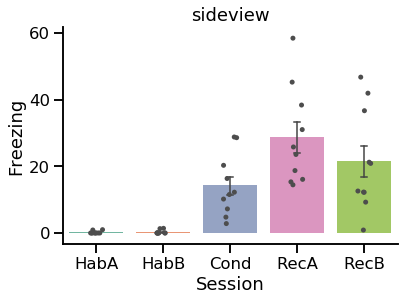

In [19]:
sns.set_context("talk")
ax = sns.barplot(y='Freezing', x='Graph_Sess', data=results_df, ci=68, capsize=.1, errwidth=1.5, palette = sns.color_palette("Set2"))
ax = sns.stripplot(y='Freezing', x='Graph_Sess', data=results_df, color='.3')
ax.set_title(exp_dict['camera'])
ax.set_xlabel('Session')
sns.despine()

In [6]:
fig = ax.get_figure()
fig.savefig(exp_dict['directory']+exp_dict['camera']+"_freezing_results.pdf", bbox_inches="tight")

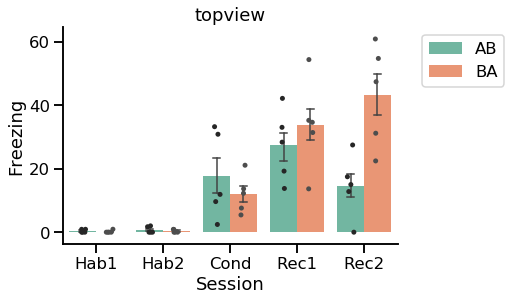

In [24]:
ax2 = sns.barplot(y='Freezing', x='Session', hue='Recall', data=results_df, ci=68, capsize=.1, errwidth=1.5, palette = sns.color_palette("Set2"))
ax2 = sns.stripplot(y='Freezing', x='Session', hue='Recall',  data=results_df, jitter=True, dodge=True, color='.3')
handles, labels = ax2.get_legend_handles_labels()
ax2.set_title(exp_dict['camera'])
ax2.legend(handles[2:6], labels[2:6], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.5)
ax2.set_xticklabels(['Hab1', 'Hab2', 'Cond', 'Rec1', 'Rec2'])
sns.despine()

In [25]:
fig = ax2.get_figure()
fig.savefig(exp_dict['directory']+exp_dict['camera']+"_freezing_results_recallgroup.pdf", bbox_inches="tight")